In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from datetime import datetime
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../source/')
sys.path.append('../methods_configuration/')
import more_itertools
import datetime
import os
import json
from precomputing import read_countrydata, read_countries 
from datetime import datetime

In [5]:
from countries_preselected import countries_preselected, countries_JHU
from paper_evaluation import evaluation_AE 
current_value = 'JHU'
H, number_startcases = 7, 0
error_estimation, error_results = "MAE", "MAE" 

In [7]:
path_data = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 
datasource, parse_column = "JHU", "Country/Region"
  
countries = countries_preselected
countries = list(set(countries_JHU)-set(["Cases_on_an_international_conveyance_Japan", 
                                            "Diamond_Princess", "Diamond Princess"])) 
 

In [8]:
stl, baseline, target = evaluation_AE(countries)

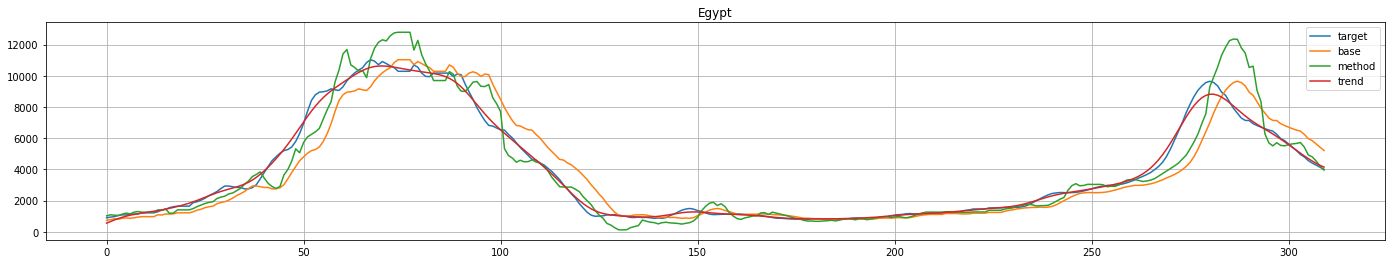

In [70]:
 # ============================================================================
# EXAMPLE -- MAIN
# ============================================================================

# ------------------------------------------------------------------------
# parameters
# ========================================================================

# data for evaluation
DATAPATH = '../data/evaluation_slope/cases/'

# forecast horizon
H = 7

# period of time to consider
start_date = datetime.strptime('2020-04-01', "%Y-%m-%d")
end_date   = datetime.strptime('2021-01-31', "%Y-%m-%d")
t0 = '2020-04-01'
T = '2021-02-01'

# for this example the trend is the convolution of the raw signal with a cubic spline
w_cubic = np.convolve(np.convolve(np.convolve(np.ones(H),np.ones(H)),np.ones(H)),np.ones(H))
w_cubic = w_cubic/np.sum(w_cubic)

# ------------------------------------------------------------------------
# variables to store estimates
# ========================================================================
e_list = [] # list to store errors
t_list = [] # list to store trend
stl_e_list = []

# ------------------------------------------------------------------------
# data loading
# ========================================================================

# get list of files
filelist = sorted(glob.glob(DATAPATH + "*.csv"))

# get country/zone names
all_zones = [os.path.splitext(os.path.basename(f))[0] for f in filelist] 

all_zones = list(set(countries_preselected).intersection(set(all_zones)))
# ------------------------------------------------------------------------
# loop over zones (region/country/sovereignty)
# ========================================================================
for zz, zone in enumerate(all_zones):

    # read file
    df = pd.read_csv(DATAPATH+zone+'.csv')#filelist[zz])

    # get time series
    dates  = [datetime.strptime(date, "%Y-%m-%d") for date in df['dates']]
     
    # get daily cases 
    # start and end indices for the considered dates  
    # target weekly forecast and baseline prediction
    target_ = target[zone] 
    baseline_ = baseline[zone]  
    stl_ = stl[zone]
    
    w_target = target_[(target_.index>=t0)&(target_.index<=T)]
    w_base = baseline_[(baseline_.index>=t0)&(baseline_.index<=T)]
    w_method = stl_[(stl_.index>=t0)&(stl_.index<=T)].sort_index() 
        
    # get trend
    dy_raw = df['cases'].values
    dy_raw = np.maximum(dy_raw,0) 
    dates = df['dates']  
    # trend is smooth weekly target
    ts = np.where(target_.index >= t0)[0][0]
    te = np.where(target_.index <= T)[0][-1]
    
    trend = np.convolve(target_.values[:,0],w_cubic,mode='same')[ts:te+1]
 
    w_base = w_base.to_numpy().squeeze()
    w_target = w_target.to_numpy().squeeze()
    w_method = w_method.to_numpy().squeeze()
    
    if zz<1:
        #checking the alignment of forecasts and the target
        plt.subplots(1,1,figsize=(24,4))
        plt.plot(w_target)
        plt.plot(w_base)
        plt.plot(w_method)
        plt.plot(trend)
        plt.grid()
        plt.title(zone)
        plt.legend(["target", "base", "method","trend"])
   
    # normalization
    norm = (w_target)

    # relative absolute error
    bench_rel_err = np.abs(w_target-w_base)/(5+norm)
    stl_rel_err = np.abs(w_target-w_method)/(5+norm)
    #bench_rel_err = np.abs(w_target-w_base)/(1+trend[1:])
    #stl_rel_err = np.abs(w_target-w_method)/(1+trend[1:])
    
    # store trend and error 
    e_list.append(np.ravel(bench_rel_err).copy())
    stl_e_list.append(np.ravel(stl_rel_err).copy())
    t_list.append(np.ravel(trend).copy())

## Fig SI 4 

6.410256410256411
12.055352236566128


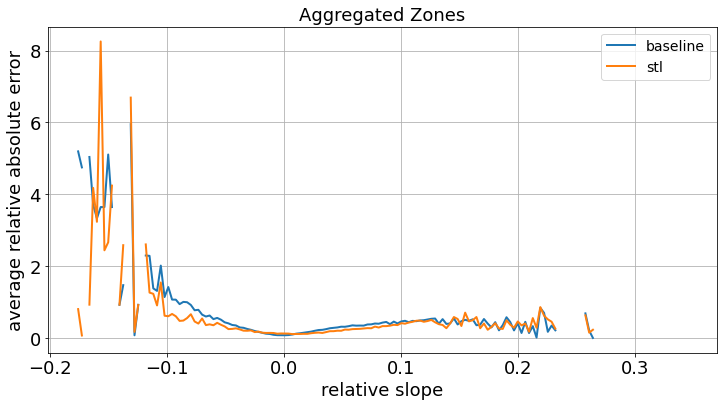

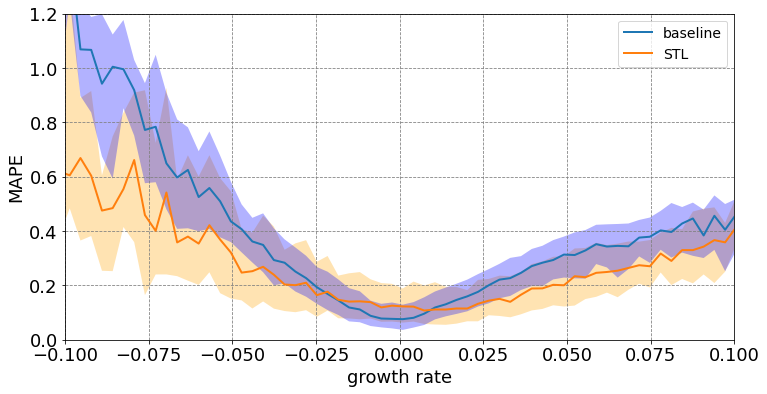

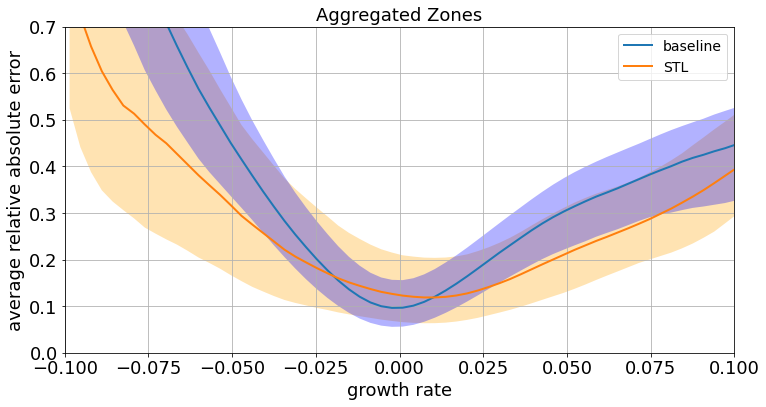

In [77]:
# plot aggregating multiple zones
# ============================================================================
binn='auto'
# average error w.r.t. slope
avg_err, bin_edges, bound_upper, bound_lower = error_slope(e_list,t_list,bins=binn)
x_center = bin_edges[:-1] + np.diff(bin_edges)/2

avg_stl_err, bin_edges, bound_upper_stl, bound_lower_stl = error_slope(stl_e_list,t_list,bins=binn)
stl_x_center = bin_edges[:-1] + np.diff(bin_edges)/2
 
# display error
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(x_center,avg_err,linewidth=2,label='baseline')
plt.plot(stl_x_center,avg_stl_err,linewidth=2,label='stl') 

plt.xlabel('relative slope')
plt.ylabel('average relative absolute error')
plt.grid(); plt.legend(fontsize=14)
plt.title('Aggregated Zones') 
for item in [ax.title,ax.xaxis.label,ax.yaxis.label]+ax.get_xticklabels()+ax.get_yticklabels():
    item.set_fontsize(18)
    

# restrict domain
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(x_center,avg_err,linewidth=2,label='baseline')
plt.plot(stl_x_center,avg_stl_err,linewidth=2,label='STL')
plt.fill_between(stl_x_center, bound_lower_stl, bound_upper_stl ,linewidth=0,color="orange",alpha=0.3)
plt.fill_between(stl_x_center, bound_lower, bound_upper,linewidth=0,color="b",alpha=0.3)
#
plt.xlim([-0.1,0.1])
plt.ylim([0,1.2])
#
plt.xlabel('growth rate')
plt.ylabel('MAPE')
plt.grid(True,which="both",ls="--",c='gray')  ; plt.legend(fontsize=14) 
for item in [ax.title,ax.xaxis.label,ax.yaxis.label]+ax.get_xticklabels()+ax.get_yticklabels():
    item.set_fontsize(18)
    
# smooth data
L = 7
h_filter = np.convolve(np.ones(L),np.ones(L)); h_filter = h_filter/np.sum(h_filter)
#
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(x_center,np.convolve(avg_err,h_filter,mode='same'),linewidth=2,label='baseline')
plt.plot(stl_x_center,np.convolve(avg_stl_err,h_filter,mode='same'),linewidth=2,label='STL')
plt.fill_between(stl_x_center, np.convolve(bound_lower_stl,h_filter,mode='same'), 
                 np.convolve(bound_upper_stl,h_filter,mode='same') ,linewidth=0,color="orange",alpha=0.3)
plt.fill_between(stl_x_center, np.convolve(bound_lower,h_filter,mode='same'),
                 np.convolve(bound_upper,h_filter,mode='same'),linewidth=0,color="b",alpha=0.3)
#
plt.xlim([-0.1,0.1])
plt.ylim([0,0.7])
#
plt.xlabel('growth rate')
plt.ylabel('average relative absolute error')
plt.grid(); plt.legend(fontsize=14)
plt.title('Aggregated Zones') 
for item in [ax.title,ax.xaxis.label,ax.yaxis.label]+ax.get_xticklabels()+ax.get_yticklabels():
    item.set_fontsize(18)